[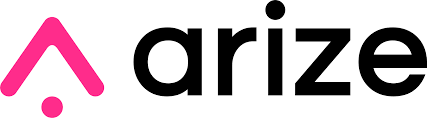](https://arize.com)

# Optimizing JSON Webpage Prompts with the Arize Prompt Learning SDK

In this cookbook, we demonstrate a use case of the Arize Prompt Learning SDK by optimizing a system prompt for GPT-4.1. The goal is to improve the model’s ability to generate accurate JSON representations of webpages in response to user queries. The dataset consists of prompts asking GPT to generate webpages, and we define 10 specific rules that the JSON outputs must satisfy. Using the SDK, we iteratively refine the prompt to achieve high accuracy on the training set, and then evaluate its performance on a separate test set.

In [ ]:
!pip install arize-phoenix-evals arize-phoenix-client tiktoken openai arize-toolkit==1.0.5

## Configuration

NUM_SAMPLES: Controls how many rows to sample from the full dataset. Set to 0 to use all available data, or a positive number to limit the sample size for faster experimentation.

TRAIN_SPLIT_FRACTION: Determines the train/test split ratio. 0.8 means 80% of data goes to training set, 20% to test set.

NUM_RULES: Specifies the number of rules to use for evaluation. This determines which prompt files to load (e.g., evaluator-prompt-10.txt vs evaluator-prompt-50.txt).

NUM_OPTIMIZATION_LOOPS: Sets how many optimization iterations to run per experiment. Each loop generates outputs, evaluates them, and refines the prompt.

These variables control the experiment scope, data splitting, evaluation criteria, and optimization intensity.

In [1]:
# CONFIG: Number of samples to use for the experiment. Adjust as needed.
NUM_SAMPLES = 100  # Number of rows to sample from the full dataset, 0 for all
TRAIN_SPLIT_FRACTION = 0.5  # Fraction of data to use for training (rest for testing)
NUM_RULES = 50  # Number of rules in the prompt - adjust based on your evaluator prompt (this is NOT working on Config)
NUM_OPTIMIZATION_LOOPS = 5  # Number of optimization loops per experiment

Run the following cell. It simply monkey patches one of our Phoenix methods for this notebook to work.

In [2]:
import nest_asyncio, re
nest_asyncio.apply()

# 1️⃣  stricter variable detector
from phoenix.evals.templates import PromptTemplate, PromptPartTemplate
_TEMPLATE_RE = re.compile(r"\{([a-zA-Z_][a-zA-Z0-9_]*)\}")
def _parse_variables_strict(self, tmpl: list[PromptPartTemplate]):  # [...]
    vars = set()
    for p in tmpl:
        vars.update(m.group(1) for m in _TEMPLATE_RE.finditer(p.template))
    return list(vars)
PromptTemplate._parse_variables = _parse_variables_strict

# 2️⃣  literal‑brace formatter
from phoenix.evals.templates import PromptPart, MultimodalPrompt
def _format_literal(self, variable_values, options=None):  # [...]
    prompt_msgs = []
    for part in self.prompt(options):
        msg = part.template
        for var in self.variables:
            msg = msg.replace(f"{{{var}}}", str(variable_values[var]))
        prompt_msgs.append(PromptPart(content_type=part.content_type, content=msg))
    return MultimodalPrompt(parts=prompt_msgs)
PromptTemplate.format = _format_literal

/opt/anaconda3/envs/base2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## OpenAI Key
We will be using OpenAI to generate the webpage jsons.

In [3]:
import os, getpass
import openai
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')
client = openai.Client(api_key=os.getenv("OPENAI_API_KEY"))

## Training and Test Datasets

Create training and test datasets, and export to Arize. 

In [4]:
import pandas as pd

dataset_1000 = pd.read_csv("https://storage.googleapis.com/arize-assets/dev-rel/prompt-learning/queries.csv")
dataset_sample = dataset_1000.sample(100) # 100 rows

# 80-20 split
train_set = dataset_sample.sample(frac=0.8, random_state=42)
test_set = dataset_sample.drop(train_set.index)

train_set.to_csv("train.csv", index=False)
test_set.to_csv("test.csv", index=False)

## Initial System Prompt

Initialize your system prompt. This is the original prompt that will be tested and optimized.

In [5]:
system_prompt = "You are an expert in JSON webpage creation. This is your task: {input}"

## Evaluator

Here we initialize our evaluator. This uses LLM as a Judge, or using an LLM to evaluate our outputs.  

We will pass in a set of 10 rules to this LLM. It will evaluate each generated JSON against these 10 rules, checking if all are satisfied.

Accordingly, it will give a correctness label, either correct or incorrect.

Additionally, it will attach an explanation as to why it chose correct or incorrect. These explanations will be used to optimize the prompt.

In [10]:
import re
import json
from phoenix.evals import OpenAIModel, llm_generate
import nest_asyncio
nest_asyncio.apply()

def find_correctness(output):
    """Extract correctness from LLM output"""
    # Look for "correct" or "incorrect" in the response
    pattern = r'"correctness":\s*"?(correct|incorrect)"?'
    match = re.search(pattern, output, re.IGNORECASE)
    if match:
        return match.group(1).lower()
    else:
        return None

def find_explanation(output):
    """Extract explanation from LLM output"""
    # Look for explanation field in JSON
    pattern = r'"explanation":\s*"([^"]*)"'
    match = re.search(pattern, output, re.IGNORECASE)
    if match:
        return match.group(1)
    else:
        return None

def evaluate_output_parser(response: str, row_index: int) -> dict:
    """Parser function for evaluate_output evaluator"""
    correctness = find_correctness(response)
    explanation = find_explanation(response)
    
    return {
        "correctness": correctness,
        "explanation": explanation
    }

def rule_checker_parser(response: str, row_index: int) -> dict:
    """Parser function for rule_checker evaluator"""
    explanation = find_explanation(response)
    
    return {
        "rule_violations": explanation
    }

def evaluate_output(dataset):
    """Evaluator that checks JSON web page correctness using llm_generate"""
    
    # Create the evaluation template
    
    with open(f"../../prompts/evaluator-prompt-{NUM_RULES}.txt", "r") as file:
        evaluation_template = file.read()

    # Create the model
    eval_model = OpenAIModel(
        model="gpt-4.1-2025-04-14",
        model_kwargs={
            "response_format": {"type": "json_object"},
            "temperature": 0
        }
    )

    # Generate evaluations using llm_generate
    evaluation_results = llm_generate(
        dataframe=dataset,
        template=evaluation_template,
        model=eval_model,
        output_parser=evaluate_output_parser,
        concurrency=40,
        verbose=True
    )

    # Merge the results back into the original dataset
    dataset = dataset.copy()
    for col in ["correctness", "explanation"]:
        if col in evaluation_results.columns:
            dataset[col] = evaluation_results[col]

    return dataset, ["correctness", "explanation"]

def rule_checker(dataset):
    """Evaluator that checks which rules are broken using llm_generate"""
    
    # Create the rule checking template
    with open(f"../../prompts/rule-checker-prompt-{NUM_RULES}.txt", "r") as file:
        rule_check_template = file.read()

    # Create the model
    eval_model = OpenAIModel(
        model_name="gpt-4.1-2025-04-14",
        model_kwargs={
            "response_format": {"type": "json_object"},
            "temperature": 0
        }
    )

    # Generate rule checks using llm_generate
    rule_check_results = llm_generate(
        dataframe=dataset,
        template=rule_check_template,
        model=eval_model,
        output_parser=rule_checker_parser,
        concurrency=40,
        verbose=True
    )

    # Merge the results back into the original dataset
    dataset = dataset.copy()
    if "rule_violations" in rule_check_results.columns:
        dataset["rule_violations"] = rule_check_results["rule_violations"]

    return dataset, ["rule_violations"]

In [11]:
def generate_output(dataset, system_prompt):
    output_model = OpenAIModel(
        model="gpt-4.1-2025-04-14",
        model_kwargs={
            "response_format": {"type": "json_object"},
            "temperature": 0
        }
    )
    outputs = llm_generate(
        dataframe=dataset,
        template=system_prompt,
        model=output_model,
        concurrency=40,
        verbose=True
    )
    return outputs["output"]
    

# Additional Metrics

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def compute_metric(y_true, y_pred, scorer="accuracy"):
    """
    Compute the requested metric for binary classification.
    y_true and y_pred should be lists or arrays of "correct"/"incorrect" labels.
    scorer: one of "accuracy", "f1", "precision", "recall"
    """
    # Map to binary
    y_true_bin = [1 if y == "correct" else 0 for y in y_true]
    y_pred_bin = [1 if y == "correct" else 0 for y in y_pred]
    if scorer == "accuracy":
        return accuracy_score(y_true_bin, y_pred_bin)
    elif scorer == "f1":
        return f1_score(y_true_bin, y_pred_bin, zero_division=0)
    elif scorer == "precision":
        return precision_score(y_true_bin, y_pred_bin, zero_division=0)
    elif scorer == "recall":
        return recall_score(y_true_bin, y_pred_bin, zero_division=0)
    else:
        raise ValueError(f"Unknown scorer: {scorer}")

# Optimization Loop
This cell implements the core prompt optimization algorithm. The loop follows a 3-step process:

Generate & Evaluate: Generate outputs using the current prompt on the test dataset and evaluate their correctness  
Train & Optimize: If results are unsatisfactory, generate outputs on the training set, evaluate them, and use the feedback to create an improved prompt
Iterate: Repeat until either the threshold is met or all loops are completed

The algorithm tracks metrics across iterations and returns detailed results including train/test accuracy scores, optimized prompts, and raw evaluation data. The optimization uses the MetaPromptOptimizer to iteratively refine the system prompt based on evaluator feedback.

Key parameters:
threshold: Target accuracy score to stop optimization
loops: Maximum number of optimization iterations
scorer: Metric to optimize (accuracy, f1, precision, recall)
num_rules: Number of evaluation rules to use

In [22]:
from arize_toolkit.extensions.prompt_optimizer import MetaPromptOptimizer

def optimize_loop(
    train_set,
    test_set,
    system_prompt,
    evaluators,
    threshold=0.7,
    loops=5,
    scorer="accuracy",
    num_rules=NUM_RULES
):
    """
    scorer: one of "accuracy", "f1", "precision", "recall"
    threshold: float, threshold for the selected metric
    num_rules: int, number of rules to use for evaluation (determines which prompt files to load)

    Returns:
        dict with keys:
            "train": list of train set scores per run
            "test": list of test set scores per run
            "prompt": list of system prompts used for each test run
            "raw": list of test set DataFrames (deepcopy) for each test run
            "num_rules": number of rules used for this experiment
    """
    import copy

    curr_loop = 1
    train_metrics = []
    test_metrics = []
    prompts = []
    raw_dfs = []

    print(f"🚀 Starting prompt optimization with {loops} iterations (scorer: {scorer}, threshold: {threshold})")
    print()
    
    # Initial test evaluation before optimization
    print(f"📊 Initial evaluation:")
    test_set["output"] = generate_output(test_set, system_prompt)
    
    test_evals_all = evaluate_output(test_set, num_rules)[0]
    test_evals = test_evals_all["correctness"]
    y_true = ["correct"] * len(test_evals)
    y_pred = test_evals
    initial_metric_value = compute_metric(y_true, y_pred, scorer=scorer)
    test_metrics.append(initial_metric_value)
    prompts.append(system_prompt)
    raw_dfs.append(copy.deepcopy(test_set))
    
    print(f"✅ Initial test {scorer}: {initial_metric_value}")
    print('\n')
    
    if initial_metric_value >= threshold:
        print(f"🎉 Initial prompt already meets threshold!")
        result = {
            "train": train_metrics,
            "test": test_metrics,
            "prompt": prompts,
            "raw": raw_dfs,
            "num_rules": num_rules
        }
        return result
    
    while loops > 0:
        print(f"📊 Loop {curr_loop}: Optimizing prompt...")
        
        # 1. Train set evaluation and optimization
        train_outputs = generate_output(train_set, system_prompt)
        train_set["output"] = train_outputs

        train_set["correctness"] = [None] * len(train_set)
        train_set["explanation"] = [None] * len(train_set)
        train_set["rule_violations"] = [None] * len(train_set)
        print("🛠️ Starting optimization...")
        optimizer = MetaPromptOptimizer(
            prompt=system_prompt,
            model_choice="gpt-4.1-2025-04-14",
            openai_api_key=os.getenv("OPENAI_API_KEY")
        )

        # Create evaluators with the correct num_rules parameter
        # this is necessary because the evaluators are defined with a default value of NUM_RULES.
        # Your evaluators might be defined differently.
        evaluators_with_rules = []
        for evaluator in evaluators:
            if evaluator.__name__ == 'evaluate_output':
                evaluators_with_rules.append(lambda ds, nr=num_rules: evaluate_output(ds, nr))
            elif evaluator.__name__ == 'rule_checker':
                evaluators_with_rules.append(lambda ds, nr=num_rules: rule_checker(ds, nr))
            else:
                evaluators_with_rules.append(evaluator)
        
        train_set, _ = optimizer.run_evaluators(
            train_set,
            evaluators_with_rules,
            feedback_columns=["correctness", "explanation", "rule_violations"]
        )

        system_prompt = optimizer.optimize(
            train_set,
            "output",
            feedback_columns=["correctness", "explanation", "rule_violations"],
            context_size_k=128000
        )

        # Evaluate train set after optimization
        train_outputs_post = generate_output(train_set, system_prompt)
        train_set_post = train_set.copy()
        train_set_post["output"] = train_outputs_post
        train_evals_post_all = evaluate_output(train_set_post, num_rules)[0]
        train_evals_post = train_evals_post_all["correctness"]
        y_true_train_post = ["correct"] * len(train_evals_post)
        y_pred_train_post = train_evals_post
        train_metric_post_value = compute_metric(y_true_train_post, y_pred_train_post, scorer=scorer)
        train_metrics.append(train_metric_post_value)
        print(f"✅ Train {scorer}: {train_metric_post_value}")

        # 2. Test set evaluation with optimized prompt
        test_set["output"] = generate_output(test_set, system_prompt)
        
        test_evals_all = evaluate_output(test_set, num_rules)[0]
        test_evals = test_evals_all["correctness"]
        y_true = ["correct"] * len(test_evals)
        y_pred = test_evals
        metric_value = compute_metric(y_true, y_pred, scorer=scorer)
        test_metrics.append(metric_value)
        prompts.append(system_prompt)
        raw_dfs.append(copy.deepcopy(test_set))
        
        print(f"✅ Test {scorer}: {metric_value}")
        print("\n")
        
        # 3. Check threshold
        if metric_value >= threshold:
            print(f"🎉 Threshold reached! Stopping optimization.")
            result = {
                "train": train_metrics,
                "test": test_metrics,
                "prompt": prompts,
                "raw": raw_dfs,
                "num_rules": num_rules
            }
            return result

        loops -= 1
        curr_loop += 1

    print(f"🔄 All {curr_loop-1} optimization loops completed.")
    result = {
        "train": train_metrics,
        "test": test_metrics,
        "prompt": prompts,
        "raw": raw_dfs,
        "num_rules": num_rules
    }
    return result

🚀 Starting prompt optimization with 1 iterations

📊 Loop 1/5: Testing current prompt...
system_prompt:  You are an expert in JSON webpage creation. This is your task: {input}


llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:18<00:00 |  1.05it/s
llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:14<00:00 |  1.41it/s
llm_generate |█████████▌| 19/20 (95.0%) | ⏳ 00:02<00:00 | 10.19it/s

✅ Test accuracy: 0.0 correct
✅ Average rules followed per query output: 0.415
🔄 20 test queries failed. Optimizing prompt...


llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:03<00:00 |  5.67it/s


🔍 Running 2 evaluator(s)...


llm_generate |██████████| 80/80 (100.0%) | ⏳ 01:08<00:00 |  1.16it/s
llm_generate |██████████| 80/80 (100.0%) | ⏳ 00:13<00:00 |  2.05it/s

   ✅ Evaluator 1: explanation
The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


llm_generate |██████████| 80/80 (100.0%) | ⏳ 00:14<00:00 |  5.39it/s


   ✅ Evaluator 2: rule_violations
🔧 Initialized TiktokenSplitter with model: gpt-4o

🔧 Creating batches with 128,000 token limit
✅ Created 1 batches
📊 Processing 80 examples in 1 batches
   ✅ Batch 1/1: Optimized


llm_generate |██████████| 80/80 (100.0%) | ⏳ 00:50<00:00 |  1.58it/s
llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:39<00:00 |  2.00s/it
llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:16<00:00 |  1.24it/s
llm_generate |█████████ | 18/20 (90.0%) | ⏳ 00:02<00:00 | 10.19it/s

✅ Test accuracy: 0.0 correct
✅ Average rules followed per query output: 0.41
Highest percentage rules followed:  0.415
Highest test accuracy: 0.0 correct


llm_generate |██████████| 20/20 (100.0%) | ⏳ 00:16<00:00 | 10.19it/s

## Now you have your optimized system prompt!

optimized_prompts contains a list of dictionaries. Each dictionary contains an iteration of the prompt and its accuracy. Instead of always picking the last prompt, which may be the result of overfitting to the training set, it may be best to pick the prompt that achieved the highest accuracy.

In [11]:
best_prompt, best_accuracy = max(optimized_prompts, key=lambda x: x["accuracy"])
best_prompt, best_accuracy

NameError: name 'optimized_prompts' is not defined